In [1]:
import imports as im
import functions as fn
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# %config InlineBackend.figure_format = 'jpg'

In [2]:
path_file = '../data/roti/2010-2020/roti'
# roti data and date
roti_map_date = []
roti_maps = []
# get date and roti maps
roti_map_date, roti_maps = fn.get_array_roti(path_file)

roti_maps_reshape = roti_maps.reshape(roti_maps.shape[0], 3600)

print("shape roti data ", roti_maps.shape)
print("shape roti data reshape", roti_maps_reshape.shape)
print("shape roti date line ", roti_map_date.shape)

shape roti data  (4469, 20, 180)
shape roti data reshape (4469, 3600)
shape roti date line  (4469, 3)


In [3]:
# get maps data
new_roti_maps = fn.roti_encode(roti_maps_reshape, 1)
# get average map for each day for training dataset
train_roti_maps = fn.roti_encode(roti_maps_reshape, 3600)

print(new_roti_maps.shape)
print(train_roti_maps.shape)

(4469, 3600)
(4469, 1)


Here is the content of training datasets with indeces

index | name
:----: | ------------
0 | avg F10-7
1 | F10-7 27-days median
2 | avg F10-7 27 days ago
3 | max scalar B
4 | max scalar B 27 days ago
5 | min BZ
6 | min BZ 27 days ago
7 | min BZ next day
8 | avg ROTI in the whole map

In [4]:
filename = "../data/imf-bz-f107-au-al/omni2_Shvf6pN7UL.lst.txt"
# get training arrays of indeces' data
data_all_arr, date_arr = fn.get_all_data(filename, train_roti_maps, roti_map_date, day_end=19, month_end=6, year_end=2022)

print(data_all_arr.shape)

(4468, 9)


In [5]:
print("ROTI date start", roti_map_date[0])
print("ROTI date end", roti_map_date[-1], "\n")

print("Indexes date start", date_arr[0])
print("Indexes date end", date_arr[-1])

ROTI date start [   1    1 2010]
ROTI date end [  19    6 2022] 

Indexes date start [   1    1 2010]
Indexes date end [  18    6 2022]


### Principal Component Analysis (PCA)

Now let's choose the number of components that we will use for further work. To do this, let's look at the ratio of variance and the number of components that explain it for all these indices

There are several reasons why dimensionality reduction is used in machine learning: to combat computational costs, to control retraining, as well as to visualize and help interpret high-dimensional datasets.

Often in machine learning, the more features there are in a dataset, the better the classifier can be trained. However, more functions also means higher computational costs. Not only can high dimensionality lead to a long learning time, a larger number of functions often leads to retooling of the algorithm as it tries to create a model that explains all the functions in the data.

Since reducing the dimensionality reduces the total number of features, this can reduce the computational requirements associated with training the model, but also helps to combat overfitting by keeping the features that will be transferred to the model fairly simple.

And we will use PCA to get a list of functions and plot which functions have the greatest explanatory power or have the greatest variance. These are the main components.

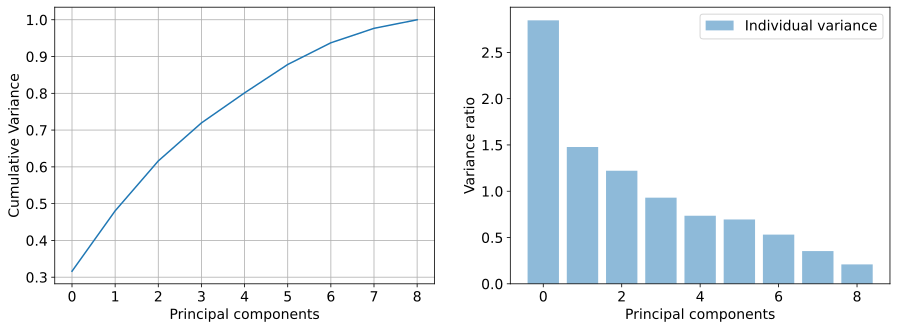

In [6]:
train_num = len(data_all_arr)
all_indexes = fn.mean_data(data_all_arr, train_num=train_num)

fn.plot_PCA(all_indexes, fontname='Times New Roman', filename="../images/pca.pdf")

Now we compute and plot the correlation matrix 

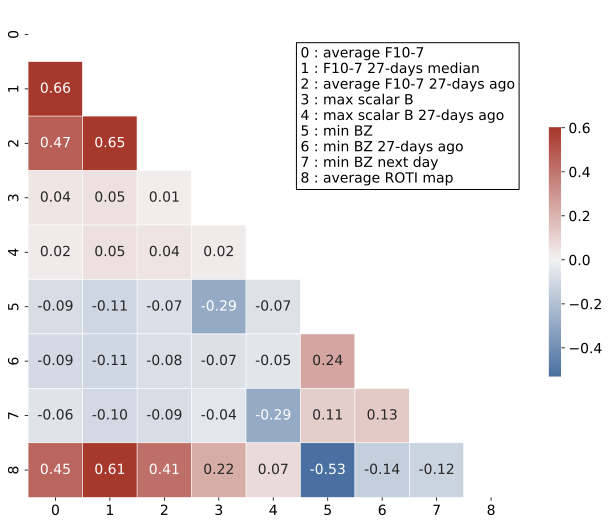

In [7]:
fn.plot_corr(all_indexes)

### Create Datasets

Randomly shuffles the elements of this dataset.

This dataset fills a buffer with buffer_size elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.

For instance, if your dataset contains 10,000 elements but buffer_size is set to 1,000, then shuffle will initially select a random element from only the first 1,000 elements in the buffer. Once an element is selected, its space in the buffer is replaced by the next (i.e. 1,001-st) element, maintaining the 1,000 element buffer.

In [8]:
# https://habr.com/ru/post/495884/

train_num = 3100
all_indexes = fn.mean_data(data_all_arr, train_num=train_num)

start_index = 0
end_index = 3100
end_index_val = 3935
# end_index = 9000
history_size = 2
target_size = 1
batch_size = 24
buffer_size = 256

x_train, y_train = fn.multivariate_data(all_indexes, new_roti_maps, start_index, end_index, history_size, target_size)
x_train_test, y_train_test = fn.multivariate_data_test(all_indexes, new_roti_maps, 0, None, history_size, target_size)
# x_train, y_train = multivariate_data(big_indexes, big_roti, start_index, end_index, history_size, target_size)
# x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
# x_train_test = x_train_test.reshape(x_train_test.shape[0], x_train_test.shape[1] * x_train_test.shape[2])

x_val, y_val = fn.multivariate_data(all_indexes, new_roti_maps, end_index, end_index_val, history_size, target_size)
# x_val, y_val = multivariate_data(big_indexes, big_roti, end_index, end_index_val, history_size, target_size)
# x_val = x_val.reshape(x_val.shape[0], x_val.shape[1] * x_val.shape[2])

train_data = im.tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.prefetch(im.tf.data.experimental.AUTOTUNE)  # Prefetch next batch while training
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
# train_data = train_data.batch(batch_size).repeat()

val_data = im.tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.prefetch(im.tf.data.experimental.AUTOTUNE)  # Prefetch next batch while training
val_data = val_data.batch(batch_size).repeat()

In [9]:
print(x_train.shape)
print(x_train_test.shape)
print(x_val.shape)

(3086, 2, 9)
(4465, 2, 9)
(833, 2, 9)


In [10]:
def inception_module(x, filters):
    branches = []
    
    # 1x1 convolution branch
    branch1 = im.Conv1D(filters=filters[0], kernel_size=1, activation='relu')(x)
    drop1 = im.Dropout(0.2)(branch1)
    branches.append(drop1)
    
    # 2x1 convolution branch
    branch2 = im.Conv1D(filters=filters[1], kernel_size=2, padding='same', activation='relu')(x)
    drop2 = im.Dropout(0.2)(branch2)
    branches.append(drop2)
    
    # 4x1 convolution branch
    branch4 = im.Conv1D(filters=filters[2], kernel_size=4, padding='same', activation='relu')(x)
    drop4 = im.Dropout(0.2)(branch4)
    branches.append(drop4)

    # this line makes residual network - if you need classic, just comment it
    branches.append(x)
    
    # Concatenate the outputs of all branches
    concatenated = im.keras.layers.concatenate(branches)
    
    return concatenated

In [11]:
def build_inception_time(input_shape, output_shape):
    inputs = im.Input(shape=input_shape)
    
    # First layer
    x = im.Conv1D(filters=128, kernel_size=1, activation='relu')(inputs)
    
    # Inception modules
    x = inception_module(x, [32, 64, 128])
    x = inception_module(x, [32, 64, 128])
    x = inception_module(x, [32, 64, 128])
    
    # Max pooling
    x = im.MaxPooling1D(pool_size=2, strides=2)(x)
    
    # Flatten the output
    x = im.Flatten()(x)
    
    # Fully connected layers
    x = im.Dense(256, activation='relu')(x)
    drop = im.keras.layers.Dropout(0.1)(x)
    x = im.Dense(output_shape, activation='sigmoid')(drop)
    
    # Create the model
    model = im.keras.models.Model(inputs=inputs, outputs=x)
    return model

In [12]:
# Define input shape and number of classes
input_shape = x_train.shape[-2:]
output_shape = new_roti_maps.shape[-1]

# Build the Inception-Time model
model = build_inception_time(input_shape, output_shape)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [15]:
epochs = 30

history = model.fit(
    train_data,
    epochs=epochs,
    steps_per_epoch=x_train.shape[0] // batch_size,
    validation_data=val_data,
    validation_steps=x_val.shape[0] // batch_size)

Epoch 1/30
128/128 [==============================] - 1s 10ms/step - loss: 0.0131 - accuracy: 0.0098 - val_loss: 0.0050 - val_accuracy: 0.0061
Epoch 2/30
128/128 [==============================] - 1s 10ms/step - loss: 0.0129 - accuracy: 0.0095 - val_loss: 0.0045 - val_accuracy: 0.0049
Epoch 3/30
128/128 [==============================] - 1s 10ms/step - loss: 0.0126 - accuracy: 0.0105 - val_loss: 0.0044 - val_accuracy: 0.0049
Epoch 4/30
128/128 [==============================] - 1s 10ms/step - loss: 0.0124 - accuracy: 0.0124 - val_loss: 0.0045 - val_accuracy: 0.0061
Epoch 5/30
128/128 [==============================] - 1s 9ms/step - loss: 0.0121 - accuracy: 0.0082 - val_loss: 0.0046 - val_accuracy: 0.0159
Epoch 6/30
128/128 [==============================] - 1s 10ms/step - loss: 0.0120 - accuracy: 0.0121 - val_loss: 0.0048 - val_accuracy: 0.0135
Epoch 7/30
128/128 [==============================] - 1s 10ms/step - loss: 0.0116 - accuracy: 0.0118 - val_loss: 0.0044 - val_accuracy: 0.0098


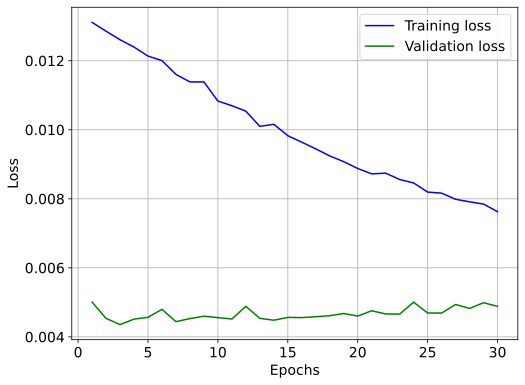

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

fn.PlotLossAcc(loss, val_loss, epochs, TrainLabel='Training loss', ValLabel='Validation loss',
               yLabel="Loss", filename="../images/loss.pdf")

1/1 [==============================] - 0s 87ms/step


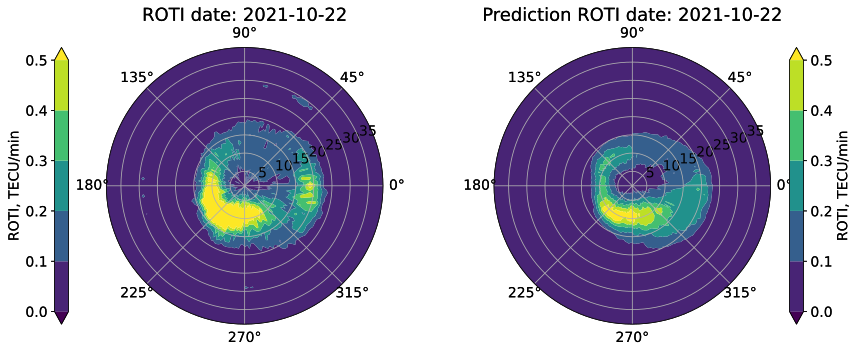

In [17]:
pdf_file = "../images/nonchalant_result.pdf"
# start = 1996
start = 4226
end = start + 1

y_pred=model.predict(x_train_test[start:end])

fn.PlotRotiPredictions(start, end, y_pred, x_train_test, roti_map_date, pdf_file=pdf_file, WriteFile=True)

1/1 [==============================] - 0s 11ms/step


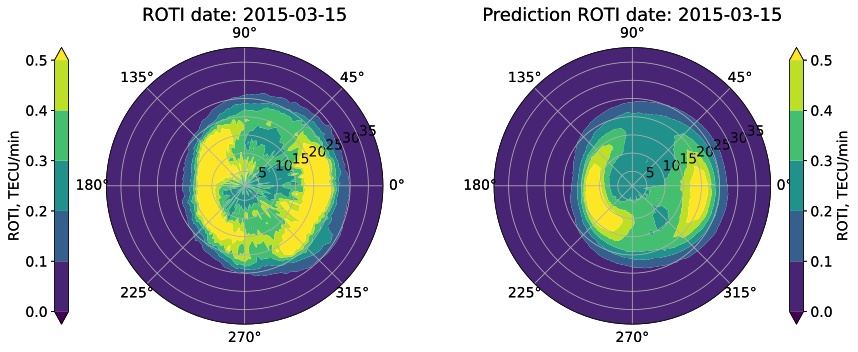

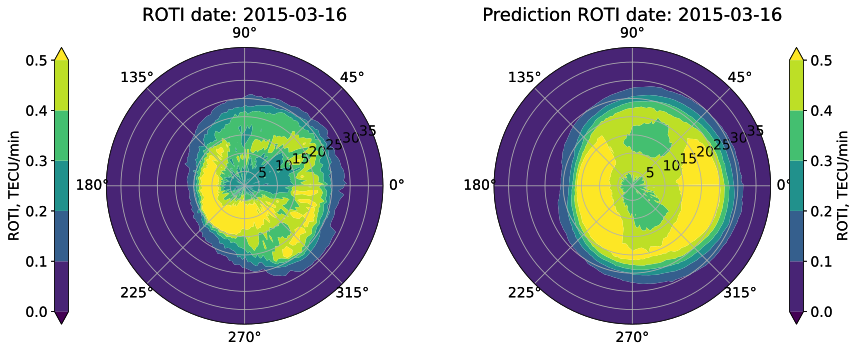

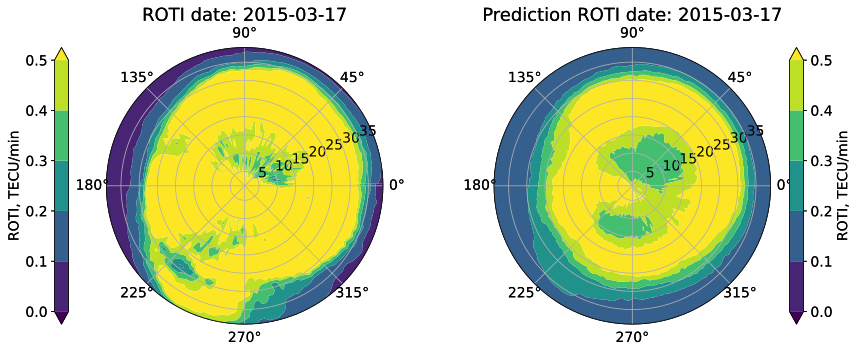

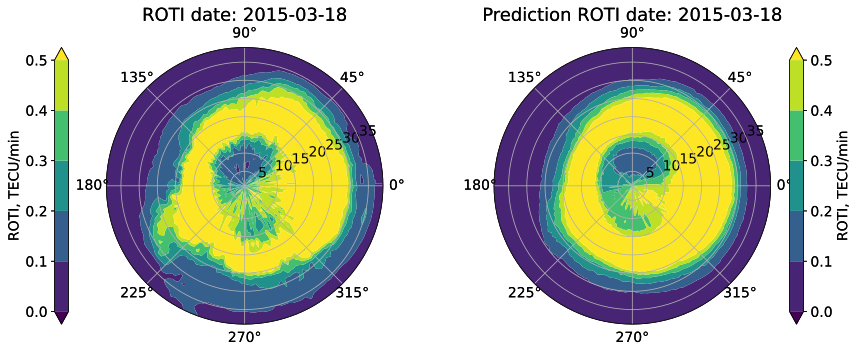

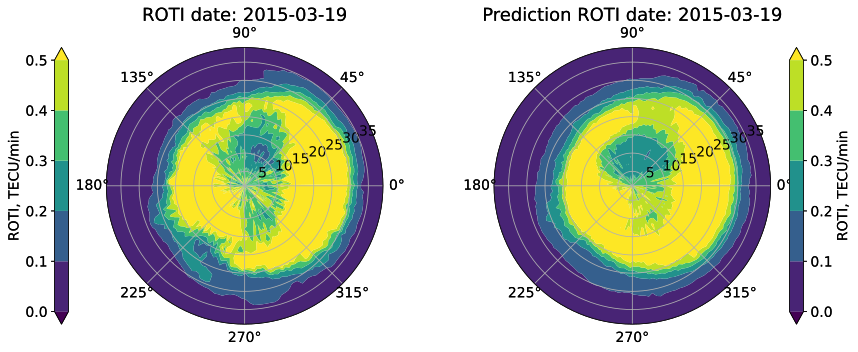

In [18]:
start = 1897
end = 1902

y_pred=model.predict(x_train_test[start:end])

fn.PlotRotiPredictions(start, end, y_pred, x_train_test, roti_map_date, pdf_file="", WriteFile=False)

1/1 [==============================] - 0s 12ms/step


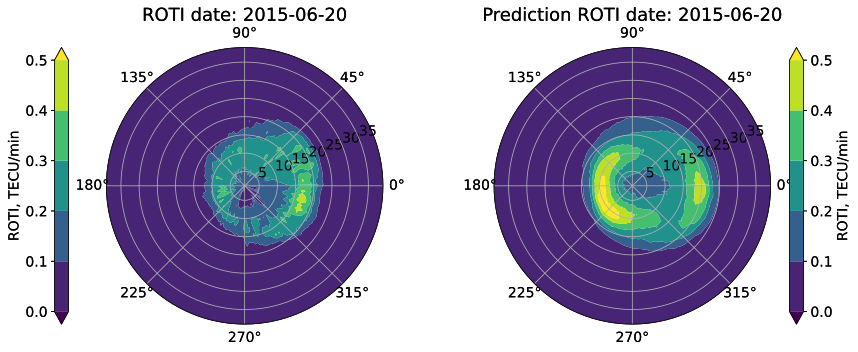

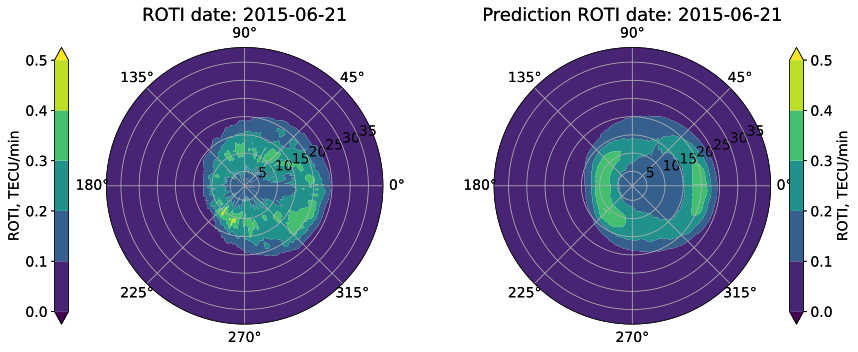

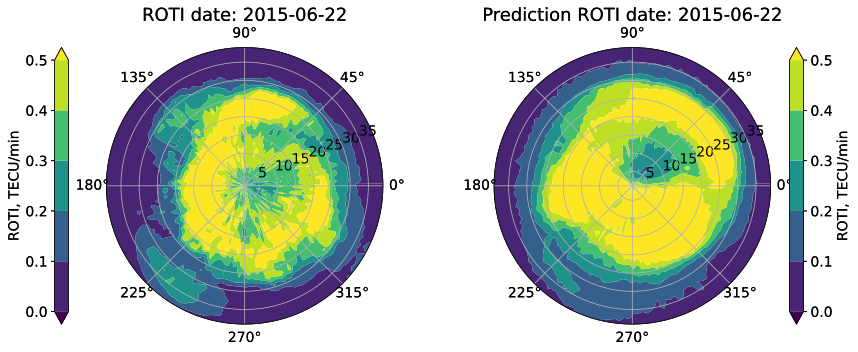

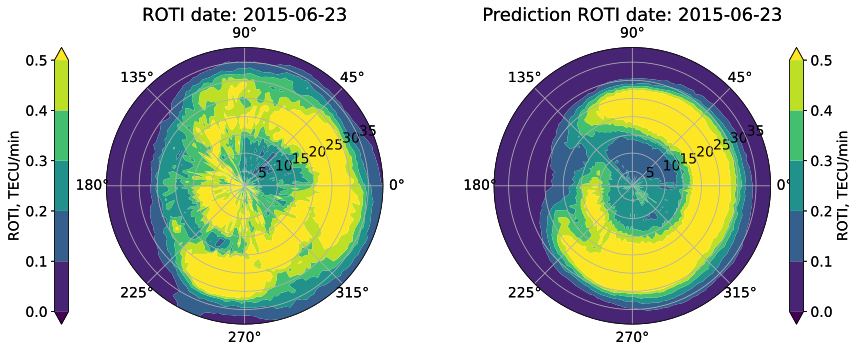

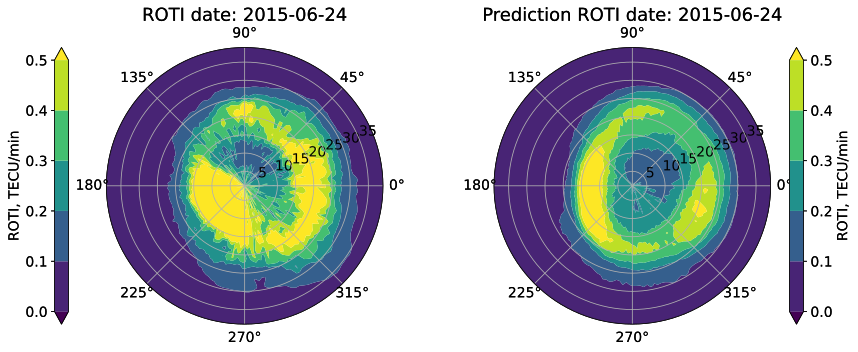

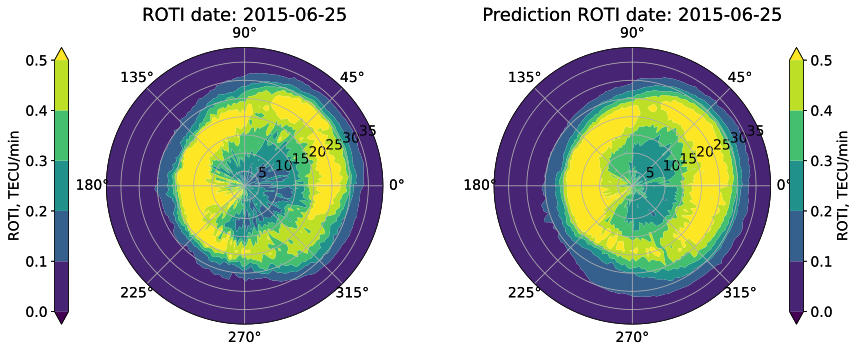

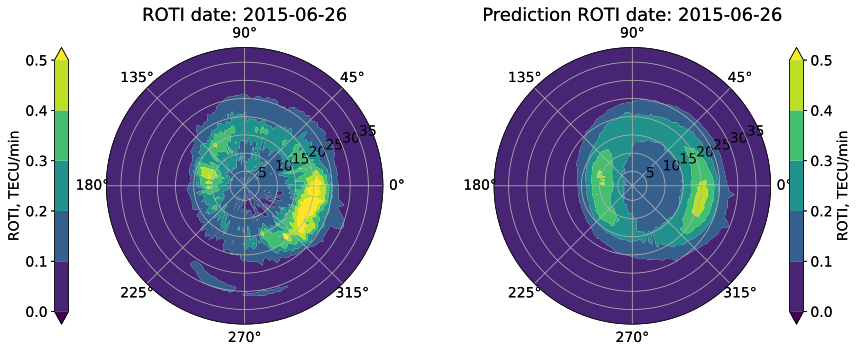

In [19]:
start = 1994
end = 2001

# start = 4455
# end = 4461

y_pred=model.predict(x_train_test[start:end])

fn.PlotRotiPredictions(start, end, y_pred, x_train_test, roti_map_date, pdf_file="", WriteFile=False)